## Import Packages

In [1]:
# package for data prep 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statistics
from scipy.stats import norm
from scipy.stats import boxcox
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

# model packages
import sklearn.model_selection as ms
from sklearn.preprocessing import StandardScaler
from scipy import stats
from scipy.stats import norm, skew
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from sklearn.linear_model import ElasticNetCV, LassoCV, Lasso, ElasticNet, LinearRegression, Ridge, RidgeCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold 
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn import linear_model
from xgboost import XGBRegressor
from mlxtend.regressor import StackingCVRegressor
%matplotlib inline

## Read & Clean Data

In [2]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")
print("Train:" + str(train_data.shape))
print("Test:" + str(test_data.shape))

Train:(1460, 81)
Test:(1459, 80)


In [3]:
## lowercase
train_data.columns = map(str.lower, train_data.columns)
test_data.columns = map(str.lower, test_data.columns)

In [4]:
train_data.drop('id',axis = 1, inplace = True)
test_data.drop('id',axis = 1, inplace = True)

In [5]:
y = train_data.saleprice ## temp-output-variable 

## SalePrice Distribution

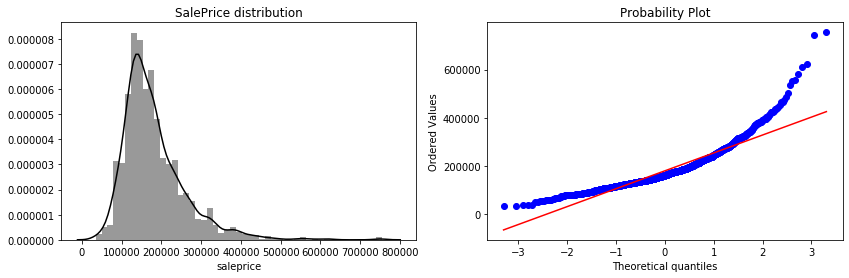

Skewness: 1.882876
Kurtosis: 6.536282


In [6]:
## "saleprice" 
fig, (ax1, res) = plt.subplots(1, 2, figsize=(14, 4))
sns.distplot(y, color = 'black', ax = ax1)
ax1.set_title('SalePrice distribution')
res = stats.probplot(y, plot=plt)
plt.show()

#Skewness, Kurtosis before log transformation
print("Skewness: %f" % y.skew())
print("Kurtosis: %f" % y.kurt())

## SalePrice Transformation

In [7]:
## log transformation
y_log = np.log1p(y) 

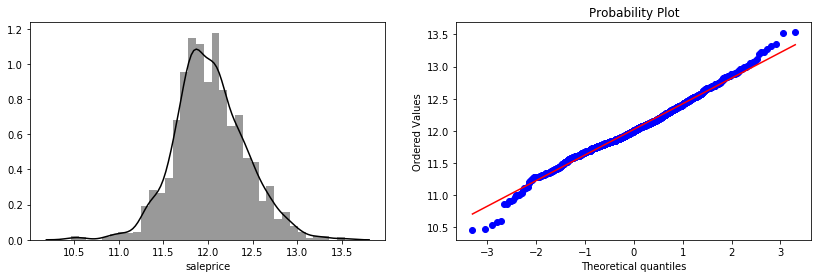

Skewness: 0.121347
Kurtosis: 0.809519


In [8]:
fig, (ax1, res) =plt.subplots(1, 2, figsize=(14,4))
sns.distplot(y_log, color = 'black', ax = ax1)
res = stats.probplot(y_log, plot=plt)
plt.show()

## after transformation Skewness, Kurtosis
print("Skewness: %f" % y_log.skew())
print("Kurtosis: %f" % y_log.kurt())

In [9]:
## storing all features 
features_all = pd.concat([train_data,test_data]).reset_index(drop=True)

## removing output variable
features_all = features_all.drop(['saleprice'], axis = 1)  
features_all.shape

(2919, 79)

## Missing Values & Imputing

In [10]:
missing = features_all.isnull().sum()
count =  features_all.isnull().count()
percent = (missing / count) * 100 
percent = percent[percent > 0].sort_values(ascending=False)

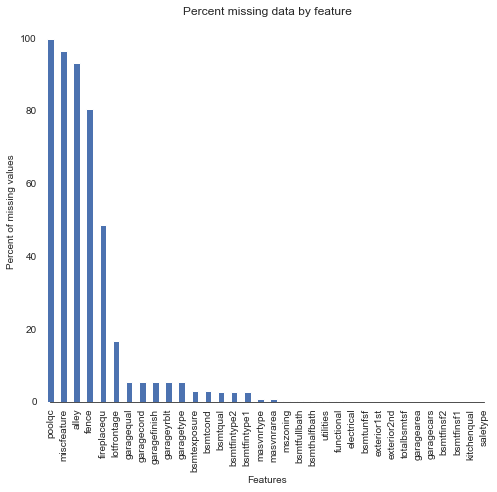

In [11]:
sns.set_style("white")
f, ax = plt.subplots(figsize=(8, 7))
sns.set_color_codes(palette='deep')
percent.plot.bar(color="b")
ax.set(ylabel="Percent of missing values")
ax.set(xlabel="Features")
ax.set(title="Percent missing data by feature")
sns.despine(trim=True, left=True)

In [12]:
def fillin_missing(features):
    # the data description states that NA refers to typical ('Typ') values
    features['functional'] = features['functional'].fillna('Typ')
    # Replace the missing values in each of the columns below with their mode
    features['electrical'] = features['electrical'].fillna("SBrkr")
    features['kitchenqual'] = features['kitchenqual'].fillna("TA")
    features['exterior1st'] = features['exterior1st'].fillna(features['exterior1st'].mode()[0])
    features['exterior2nd'] = features['exterior2nd'].fillna(features['exterior2nd'].mode()[0])
    features['saletype'] = features['saletype'].fillna(features['saletype'].mode()[0])

    # the data description stats that NA refers to "No Pool"
    features["poolqc"] = features["poolqc"].fillna("None")
    # Replacing the missing values with 0, since no garage = no cars in garage
    for col in ('garageyrblt', 'garagearea', 'garagecars'):
        features[col] = features[col].fillna(0)
    # Replacing the missing values with None
    for col in ['garagetype', 'garagefinish', 'garagequal', 'garagecond']:
        features[col] = features[col].fillna('None')
    # NaN values for these categorical basement features, means there's no basement
    for col in ('bsmtqual', 'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfintype2'):
        features[col] = features[col].fillna('None')
        
    # We have no particular intuition around how to fill in the rest of the categorical features
    # So we replace their missing values with None
    objects = []
    for i in features.columns:
        if features[i].dtype == 'object':
            objects.append(i)
    features.update(features[objects].fillna('None'))
        
    # And we do the same thing for numerical features, but this time with 0s
    numeric = []
    for i in features.columns:
        if features[i].dtype != "object":
            numeric.append(i)
    features.update(features[numeric].fillna(0))    
    return features

features_all = fillin_missing(features_all)


missing = features_all.isnull().sum()
count =  features_all.isnull().count()
percent = (missing / count) * 100 
percent = percent[percent > 0].sort_values(ascending=False)
missing[0:5]
## No missing variables 

1stflrsf        0
2ndflrsf        0
3ssnporch       0
alley           0
bedroomabvgr    0
dtype: int64

## Create New Features

In [13]:
## new features
features_all['total_homequal'] = features_all['overallqual'] + features_all['overallcond']
features_all['total_sf'] = features_all['totalbsmtsf'] + features_all['1stflrsf'] + features_all['2ndflrsf']
features_all['year_blt_r'] = features_all['yearbuilt'] + features_all['yearremodadd']
features_all['total_sqr'] = features_all['bsmtfinsf1'] + features_all['bsmtfinsf2'] + features_all['1stflrsf'] + features_all['2ndflrsf']

In [14]:
## checking if new features included
features_all.shape

(2919, 83)

## Fixing Skewness

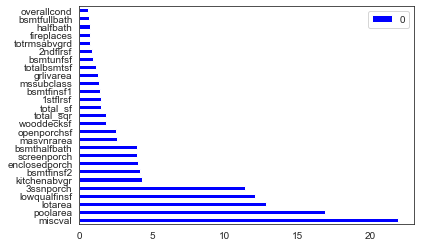

In [15]:
## If skewness is between -0.5 and 0.5, the distribution is approximately symmetric.
numeric = []
for i in features_all.columns:
    if features_all[i].dtype != "object":
        numeric.append(i)
skews = features_all[numeric].apply(lambda x: skew(x)).sort_values(ascending=False)
skewh = skews[skews > 0.5] ##  According the definition of skewness, range of -0.5 and 0.5 is symmetric
skewh = pd.DataFrame(skewh)
skewh_index = skewh.index
#skewh
skewh.plot.barh(color = "blue")
plt.show()

C:\Users\kevin\Anaconda3\lib\site-packages\scipy\stats\stats.py:3038: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


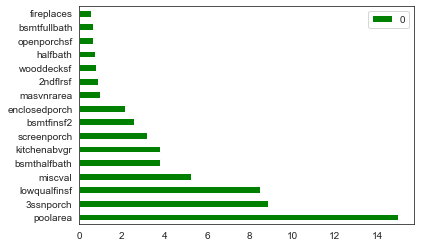

In [16]:
for i in skewh_index:
   features_all[i] = boxcox1p(features_all[i], boxcox_normmax(features_all[i] + 1))
skews = features_all[skewh_index].apply(lambda x: skew(x)).sort_values(ascending=False)
skewh = skews[skews > 0.5]
skewh = pd.DataFrame(skewh)
skewh.plot.barh(color = "green")
plt.show()

## Explore Outliers Using Ridge and ElasticNet

In [17]:
features_all.shape

(2919, 83)

In [18]:
# splitting new train and test set
train = features_all.iloc[:len(y), :]
test = features_all.iloc[len(y):, :]


In [19]:
train_dummies = pd.get_dummies(pd.concat((train, test), axis=0)).iloc[: train.shape[0]]

In [20]:
rr = Ridge(alpha=13)
rr.fit(train_dummies, y_log)
np.sqrt(-cross_val_score(rr, train_dummies, y_log, cv=5, scoring="neg_mean_squared_error")).mean()

0.12608007890246617

In [21]:
y_pred = rr.predict(train_dummies)
resid = y_log - y_pred
mean_resid = resid.mean()
std_resid = resid.std()
z = (resid - mean_resid) / std_resid
z = np.array(z)
outliers1 = np.where(abs(z) > abs(z).std() * 3)[0]
outliers1

array([  13,   30,   88,  142,  277,  308,  313,  328,  377,  410,  462,
        495,  523,  560,  581,  588,  628,  632,  658,  681,  688,  710,
        714,  726,  728,  738,  774,  803,  812,  874,  898,  916,  968,
        970, 1046, 1062, 1122, 1181, 1182, 1212, 1298, 1324, 1383, 1423,
       1432, 1453], dtype=int64)

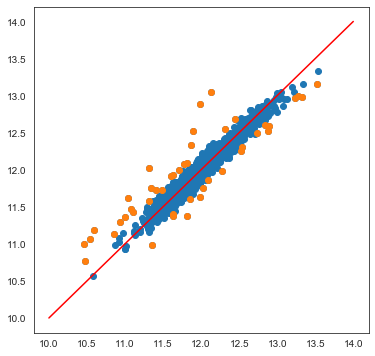

In [22]:
plt.figure(figsize=(6, 6))
plt.scatter(y_log, y_pred)
plt.scatter(y_log.iloc[outliers1], y_pred[outliers1])
plt.plot(range(10, 15), range(10, 15), color="red")

In [23]:
er = ElasticNet(alpha=0.001, l1_ratio=0.58)
er.fit(train_dummies, y_log)
np.sqrt(-cross_val_score(rr, train_dummies, y_log, cv=5, scoring="neg_mean_squared_error")).mean()

C:\Users\kevin\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04197888726368504, tolerance: 0.02327976343365451
  positive)


0.12608007890246617

In [24]:
y_pred = er.predict(train_dummies)
resid = y_log - y_pred
mean_resid = resid.mean()
std_resid = resid.std()
z = (resid - mean_resid) / std_resid
z = np.array(z)
outliers2 = np.where(abs(z) > abs(z).std() * 3)[0]
outliers2

array([  30,   88,  142,  185,  277,  328,  410,  462,  495,  523,  560,
        583,  588,  628,  632,  658,  666,  681,  688,  710,  714,  726,
        728,  738,  774,  803,  812,  874,  898,  968,  970, 1046, 1062,
       1122, 1181, 1182, 1211, 1212, 1216, 1298, 1324, 1383, 1423, 1432,
       1453], dtype=int64)

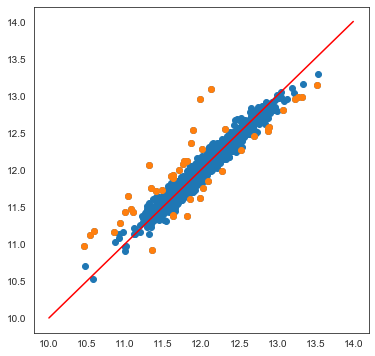

In [25]:
plt.figure(figsize=(6, 6))
plt.scatter(y_log, y_pred)
plt.scatter(y_log.iloc[outliers2], y_pred[outliers2])
plt.plot(range(10, 15), range(10, 15), color="red")

In [26]:
outliers = []
for i in outliers1:
    for j in outliers2:
        if i == j:
            outliers.append(i)
            outliers_index = outliers.index 

## Delete Outliers

In [27]:
## outliers
train = train.drop([30, 88, 142, 277, 328, 410, 462, 495, 523, 533, 581, 588, 628, 632, 681, 688, 710, 714, 728, 774, 812, 874, 898, 916, 968, 970, 1181, 1182, 1298, 1324, 1383, 1423, 1432, 1453])
## update features_all
features_all = pd.concat([train,test]).reset_index(drop=True)
features_all_dummies = pd.get_dummies(features_all).reset_index(drop=True)

In [28]:
## extract output variable: y 
train_data = train_data.drop([30, 88, 142, 277, 328, 410, 462, 495, 523, 533, 581, 588, 628, 632, 681, 688, 710, 714, 728, 774, 812, 874, 898, 916, 968, 970, 1181, 1182, 1298, 1324, 1383, 1423, 1432, 1453])
y = np.log1p(train_data.saleprice)

In [29]:
x_train = features_all_dummies.iloc[:len(y), :]
x_test = features_all_dummies.iloc[len(y):, :]

# Model

In [30]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)

def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def rmse_cv(model):
    rmse = np.sqrt(-cross_val_score(model, x_train, y, scoring="neg_mean_squared_error", cv=kf))
    return (rmse)

## Set up

In [31]:
alphas_r = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
alphas_l = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
alphas_e = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
l1ratio_e = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

In [32]:
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=alphas_r, cv=kf))

lasso = make_pipeline(RobustScaler(), LassoCV(max_iter=1e7, alphas=alphas_l, random_state=42, cv=kf))

elasticnet = make_pipeline(RobustScaler(), ElasticNetCV(max_iter=1e7, alphas=alphas_e, cv=kf, l1_ratio=l1ratio_e)) 

gbr = GradientBoostingRegressor(n_estimators=3000, 
                                learning_rate=0.05, 
                                max_depth=4, max_features='sqrt', 
                                min_samples_leaf=15, min_samples_split=10, 
                                loss='huber', random_state =42) 

rf = RandomForestRegressor(n_estimators=1200,
                          max_depth=15,
                          min_samples_split=5,
                          min_samples_leaf=5,
                          max_features=None,
                          oob_score=True,
                          random_state=42)

xgboost = XGBRegressor(learning_rate=0.01,
                       n_estimators=6000,
                       max_depth=4,
                       min_child_weight=0,
                       gamma=0.6,
                       subsample=0.7,
                       colsample_bytree=0.7,
                       objective='reg:squarederror',
                       nthread=-1,
                       scale_pos_weight=1,
                       seed=27,
                       reg_alpha=0.00006,
                       random_state=42)

stack_gen = StackingCVRegressor(regressors=(ridge, lasso, elasticnet, gbr, rf),
                                meta_regressor=xgboost,
                                use_features_in_secondary=True)

## Train

In [33]:
score = rmse_cv(ridge)
print("ridge: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), )

score = rmse_cv(lasso)
print("lasso: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), )

score = rmse_cv(elasticnet)
print("elastic net: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), )

score = rmse_cv(gbr)
print("gbr: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), )

score = rmse_cv(rf)
print("random forest: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), )

score = rmse_cv(xgboost)
print("xgboost: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), )

ridge: 0.0857 (0.0052)

lasso: 0.0854 (0.0060)

elastic net: 0.0853 (0.0059)

gbr: 0.0899 (0.0077)

random forest: 0.1166 (0.0098)

xgboost: 0.1184 (0.0105)



## Fit

In [34]:
print('stack_gen')
stack_gen_model = stack_gen.fit(np.array(x_train), np.array(y))

print('lasso')
lasso_model_full_data = lasso.fit(x_train, y)

print('ridge')
ridge_model_full_data = ridge.fit(x_train, y)

print('elastic net')
elastic_model_full_data = elasticnet.fit(x_train, y)

print('gradient boosting')
gbr_model_full_data = gbr.fit(x_train, y)

print('random forest')
rf_model_full_data = rf.fit(x_train, y)

print('xgboost')
xgb_model_full_data = xgboost.fit(x_train, y)


stack_gen
lasso
ridge
elastic net
gradient boosting
random forest
xgboost


## Blend

In [76]:
def blended_predictions(x):
    return ((0.1 * lasso_model_full_data.predict(x)) + \
            (0.15 * ridge_model_full_data.predict(x)) + \
            (0.15 * elastic_model_full_data.predict(x)) + \
            (0.15 * gbr_model_full_data.predict(x)) + \
            (0.05 * rf_model_full_data.predict(x)) + \
            (0.05 * xgb_model_full_data.predict(x)) + \
            (0.35 * stack_gen_model.predict(np.array(x))))

In [77]:
blended_score = rmsle(y, blended_predictions(x_train))
print('RMSLE score on train data:')
print(blended_score)

RMSLE score on train data:
0.059889374902743854
